Episode 1 | Reward: 290.8157 | Epsilon: 0.9950 | Best: 290.8157
Episode 2 | Reward: 74.6090 | Epsilon: 0.9900 | Best: 290.8157
Episode 3 | Reward: 240.3330 | Epsilon: 0.9851 | Best: 290.8157
Episode 4 | Reward: 273.3242 | Epsilon: 0.9801 | Best: 290.8157
Episode 5 | Reward: 16.5686 | Epsilon: 0.9752 | Best: 290.8157
Episode 6 | Reward: 204.1206 | Epsilon: 0.9704 | Best: 290.8157
Episode 7 | Reward: 145.0837 | Epsilon: 0.9655 | Best: 290.8157
Episode 8 | Reward: 4.4728 | Epsilon: 0.9607 | Best: 290.8157
Episode 9 | Reward: 42.1815 | Epsilon: 0.9559 | Best: 290.8157
Episode 10 | Reward: 381.7764 | Epsilon: 0.9511 | Best: 381.7764
Episode 11 | Reward: 361.5649 | Epsilon: 0.9464 | Best: 381.7764
Episode 12 | Reward: 29.0518 | Epsilon: 0.9416 | Best: 381.7764
Episode 13 | Reward: 412.7426 | Epsilon: 0.9369 | Best: 412.7426
Episode 14 | Reward: 37.0228 | Epsilon: 0.9322 | Best: 412.7426
Episode 15 | Reward: 2.5130 | Epsilon: 0.9276 | Best: 412.7426
Episode 16 | Reward: 388.2724 | Epsilon: 0.

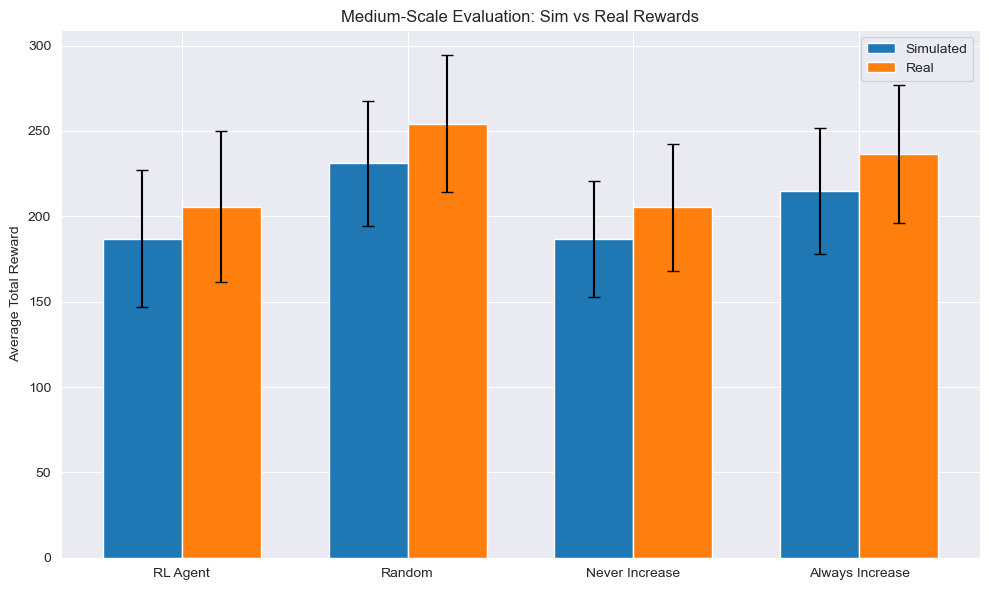

In [6]:
import numpy as np
import torch
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from src.rl_env import CreditLimitEnv
from src.dqn import DQN, train_dqn
from src.evaluation import DQNAgent, evaluate_policy, plot_policy_comparison

# === Step 1: Load and Sample Data (Medium-Scale Test) ===
df_full = pd.read_csv("data/processed/cleaned_df.csv")
df_subset = df_full.sample(n=5000, random_state=42).reset_index(drop=True)

# === Step 2: Initialize Environment with Provision Bins ===
provision_bins = np.arange(-0.5, 1.51, 0.01)
globals()["provision_bins"] = provision_bins
env = CreditLimitEnv(df_subset, provision_bins=provision_bins)

# === Step 3: Train DQN Model (Longer Run) ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = len(env.state_space)
output_dim = len(env.action_space)

model = DQN(input_dim, output_dim).to(device)
model, _, _, _ = train_dqn(env, episodes=30)  # Still fast but more learning

# === Step 4: Wrap Agent ===
agent = DQNAgent(model, env.action_space)

# === Step 5: Evaluate Agent and Benchmarks (10 runs each) ===
rl_sim, rl_real     = evaluate_policy(agent, env, n_runs=10)
rand_sim, rand_real = evaluate_policy(None, env, n_runs=10, benchmark="random")
no_sim, no_real     = evaluate_policy(None, env, n_runs=10, benchmark="never_increase")
all_sim, all_real   = evaluate_policy(None, env, n_runs=10, benchmark="always_increase")

# === Step 6: Organize Results ===
sim_results = {
    "RL Agent": rl_sim,
    "Random": rand_sim,
    "Never Increase": no_sim,
    "Always Increase": all_sim
}

real_results = {
    "RL Agent": rl_real,
    "Random": rand_real,
    "Never Increase": no_real,
    "Always Increase": all_real
}

# === Step 7: Print Summary ===
print("=== Simulated Rewards ===")
for k, v in sim_results.items():
    print(f"{k:17s}: {np.mean(v):.4f}")

print("\n=== Real (Ground-Truth) Rewards ===")
for k, v in real_results.items():
    print(f"{k:17s}: {np.mean(v):.4f}")

# === Step 8: Plot Comparison ===
plot_policy_comparison(sim_results, real_results, title="Medium-Scale Evaluation: Sim vs Real Rewards")